In [1]:
import netCDF4
import matplotlib.pyplot as plt
import pyugrid

import matplotlib.collections
import matplotlib.patches
import matplotlib.colors
import cmocean.cm
import numpy as np


%matplotlib inline

print('netcdf4', netCDF4.__version__)
print('pyugrid', pyugrid.__version__)

netcdf4 1.2.4
pyugrid 0.2.2


In [2]:
# a model of the Western Scheldt
# The Western Scheldt is the access point to the Port of Antwerp. 
url = ('http://opendap.deltares.nl/thredds/dodsC/opendap'
       '/deltares/Delft3D/netcdf_example_files/westernscheldt_sph_map.nc')

In [3]:
# open the opendap url
ds = netCDF4.Dataset(url)
# read it as a UGrid
ug = pyugrid.UGrid.from_nc_dataset(ds)

In [4]:
# now we lookup the faces that are not completely filled
non_filled_faces, = np.nonzero(ug.faces.mask.any(axis=1))
# or we can look up how many nodes are in a cell
n_nodes_per_face = (~ug.faces.mask).sum(axis=1)
# you could use this to speed up rendering by plotting triangles as is and splitting up quads
# or we can use it to create a list of non equally size coordinates (a ragged array)
ragged = [
    face[:n_nodes].filled()
    for n_nodes, face 
    in zip(n_nodes_per_face, ug.faces)
]
print("we changed", ug.faces[non_filled_faces[0]], "into", ragged[non_filled_faces[0]])

we changed [232 711 600 --] into [232 711 600]


In [5]:
# list of coordinates of all the triangles and quads
faces = [ug.nodes[face] for face in ragged]
# lookup velocity in x,y directions at last timestep
ucx = ds.variables['mesh2d_ucx'][-1,:]
ucy = ds.variables['mesh2d_ucy'][-1,:]
# compute absolute velocity
var = np.sqrt(ucx**2 +  ucy**2)

In [6]:
domain = 0, var.max()
# define a normalization function
N = matplotlib.colors.Normalize(*domain)
# pick a corresponding colormap
cmap = cmocean.cm.speed

# Let's draw general polygons
patches = (matplotlib.patches.Polygon(face) for face in faces)
# add them all at once
patch_collection = matplotlib.collections.PatchCollection(patches, edgecolor='none')
# set the face colors to the color of the data
patch_collection.set_facecolor(cmap(N(var)))

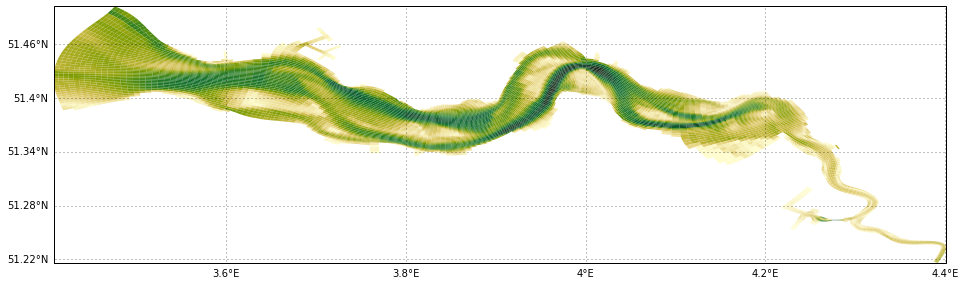

In [7]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 6),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax
fig, ax = make_map()
ax.add_collection(patch_collection)
ax.autoscale()